In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

DUDAS / SUGERENCIAS
1) ¿ var1(t-1) es parte del output? no debería, debería ser parte del input y eso es fácil de cambiar, cuando se seleccionan las columnas de entrada y salida en "split_data") 

2) Los resultados son para todos los edificios juntos, ¿podemos probar a hacerlos por separado?

3) Hay algún problema que hace que no pueda descargar la imagen última en pdf

In [3]:
#Cargamos los datos agrupados por habitación
datos = pd.read_csv("data-room-10T-all.csv", sep = ";", index_col=0)
datos.iloc[100:105]

,room,block,dif_cons,cons_total,V2,V12,V5,V4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt
Fecha,,,,,,,,,,,,,,,
2021-01-01 00:20:00+00:00,B1.1.006,A,0.22,1.77,15.3,25.0,1.0,0.0,3.4,64.0,0.0,0.2,191.3,0.0,-2.7
2021-01-01 00:20:00+00:00,B1.3.007,A,0.22,1.77,23.2,23.0,1.0,0.0,3.4,64.0,0.0,0.2,191.3,0.0,-2.7
2021-01-01 00:20:00+00:00,B1.1.026,A,0.22,1.77,22.6,24.0,2.0,0.0,3.4,64.0,0.0,0.2,191.3,0.0,-2.7
2021-01-01 00:20:00+00:00,B1.3.006,A,0.22,1.77,22.9,24.0,2.0,0.0,3.4,64.0,0.0,0.2,191.3,0.0,-2.7
2021-01-01 00:20:00+00:00,B1.3.018.3,A,0.22,1.77,26.1,22.0,1.0,0.0,3.4,64.0,0.0,0.2,191.3,0.0,-2.7


In [3]:
#Nos quedamos con los datos de uno de los edificios
edificio = ["B"]
mask = datos['block'].isin(edificio)
datos = datos.loc[mask]
#Seleccionamos la habitación(es) a investigar
room = ["B1.1.014"]
mask = datos['room'].isin(room)
datos_room = datos.loc[mask]
#Quitamos las columnas que no vamos a usar para predecir 
datos_room = datos_room.drop(columns=['dif_cons','cumsum','block','room', 'V6'],axis=1) #Quitamos V6 porque si el HVAC está apagado no va a importar
datos_room.head()

,V2,V12,V4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt
Fecha,,,,,,,,,,
2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:10:00+00:00,20.1,29.0,0.0,3.6,65.4,0.0,0.6,180.7,0.0,-2.3
2021-01-01 00:20:00+00:00,20.1,29.0,0.0,3.4,64.0,0.0,0.2,191.3,0.0,-2.7
2021-01-01 00:30:00+00:00,20.1,29.0,0.0,3.5,63.9,0.0,0.2,251.2,0.0,-2.7
2021-01-01 00:40:00+00:00,20.1,29.0,0.0,3.3,63.2,0.0,0.1,241.2,0.0,-3.0


In [4]:
#Número de cambios totales en el estado en la habitación estudiada
print(sum(datos_room['V4'].diff().abs()==1))

#Esperamos que los cambios de OFF a ON y viceversa sean los mismo o difieran en uno, según cuando se tome el primer y/o último dato
#OJO: si ocurre eso nos va a dar problemas, para solucionarlo modificar los arrays usando condiciones de encendido/apagado
#en el primer/último registro. *Esto es lo que daba problemas en la habitación B1.1.014

#Número de cambios de OFF a ON (la diferencia será +1)
print(sum(datos_room['V4'].diff()==1))

#Número de cambios de ON a OFF (la diferencia será -1) <---  Esto es lo que nos interesa ahora mismo
print(sum(datos_room['V4'].diff()==-1))

78
39
39


In [5]:
#V4 como string
text = datos_room.V4.fillna(2).astype(int).astype(str).str.cat()
#Tiempo que queremos el OFF después del ON
time = 60
#Secuencia del tipo 1xxx ,donde x son los 0's que pongamos según el tiempo de apagado
#Podemos buscar cualquier secuencia de ON/OFF
sequence = list(np.repeat(str(0),time/10))
sequence.insert(0,'1')
sequence= ''.join(sequence)
pattern = f'(?:{sequence})'
findings = re.finditer(pattern, text)
events = [(m.start(0), m.end(0)) for m in findings]
events

[(5010, 5017),
 (10141, 10148),
 (15057, 15064),
 (24116, 24123),
 (24141, 24148),
 (25122, 25129),
 (25297, 25304),
 (25688, 25695),
 (25706, 25713),
 (25719, 25726),
 (26734, 26741),
 (27003, 27010),
 (27148, 27155),
 (27177, 27184),
 (27299, 27306),
 (27754, 27761),
 (27889, 27896),
 (35048, 35055),
 (35079, 35086),
 (35210, 35217),
 (35359, 35366),
 (37378, 37385),
 (37789, 37796),
 (37828, 37835),
 (37978, 37985),
 (38372, 38379),
 (45854, 45861),
 (46131, 46138),
 (46155, 46162),
 (46291, 46298),
 (46439, 46446),
 (46905, 46912),
 (47283, 47290),
 (47882, 47889),
 (48290, 48297),
 (49873, 49880)]

In [6]:
#Vemos que funciona bien
datos_room.iloc[5010:5017]

,V2,V12,V4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt
Fecha,,,,,,,,,,
2021-02-04 19:00:00+00:00,28.3,29.0,1.0,13.5,76.6,0.0,0.1,86.2,0.0,9.5
2021-02-04 19:10:00+00:00,28.2,29.0,0.0,13.4,77.4,0.0,0.1,88.9,0.0,9.6
2021-02-04 19:20:00+00:00,28.4,29.0,0.0,13.1,77.6,0.0,0.1,196.0,0.0,9.3
2021-02-04 19:30:00+00:00,28.6,29.0,0.0,12.7,78.7,0.0,0.4,198.8,0.0,9.1
2021-02-04 19:40:00+00:00,28.5,29.0,0.0,12.5,79.5,0.0,0.1,221.0,0.0,9.1
2021-02-04 19:50:00+00:00,28.3,29.0,0.0,12.3,79.8,0.0,0.2,200.1,0.0,8.9
2021-02-04 20:00:00+00:00,28.0,29.0,0.0,12.3,80.4,0.0,0.6,193.0,0.0,9.0


# LSTM

In [4]:
def my_func(datos, block, t_limit, n_obs_antes, n_obs_despues, mode): #Añadir mode para decir si es ON -> OFF, OFF->ON y el tiempo de cada uno
    
    #Inicializamos un df vacío para guardar la salida
    agg_final = pd.DataFrame()
    
    #Seleccionamos habitaciones de un edificio
    edificio = block
    mask = datos['block'].isin(edificio)
    datos = datos.loc[mask]
    rooms = datos['room'].unique()
    
    #Iteramos sobre las habitaciones
    for room in rooms:
        mask = datos['room'].isin([room])
        datos_room = datos.loc[mask]
        if mode == 1:
            datos_room = datos_room.drop(columns=['dif_cons','cumsum','block','room','V6', 'V12'],axis=1) #Para 1000000 quitamos V12
        else:
            print('mode error')
            break
        #V4 como string
        text = datos_room.V4.fillna(2).astype(int).astype(str).str.cat()
        #Tiempo que queremos el OFF después del ON
        time = t_limit
        #Secuencia del tipo 1xxx ,donde x son los 0's que pongamos según el tiempo de apagado
        #Podemos buscar cualquier secuencia de ON/OFF
        if mode == 1:        
            sequence = list(np.repeat(str(0),time/10))
            sequence.insert(0,'1')
            sequence= ''.join(sequence)
            pattern = f'(?:{sequence})'
            findings = re.finditer(pattern, text)
            events = [(m.start(0)) for m in findings]  
        #De momento el único modo de esta función es para tipo 1000000
        elif mode != 1 :
            print('mode error')
            break
        
        for i in range(len(events)):
            ref_inicio = events[i]+1
            df1 = datos_room.iloc[range(ref_inicio - n_obs_antes, ref_inicio + n_obs_despues),:]

            data = df1
            n_vars = 1 if type(data) is list else data.shape[1]
            df = pd.DataFrame(data)
            cols, names = list(), list()
            
            # input sequence (t-n, ... t-1)
            n_in=n_obs_antes
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
                
            # forecast sequence (t, t+1, ... t+n)
            n_out =n_obs_despues
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            agg = pd.concat(cols, axis=1)
            agg.columns = names

            dropnan = True
            if dropnan:
                agg.dropna(inplace=True)

            agg_final = pd.concat([agg_final, agg])

    return agg_final

In [8]:
datos = pd.read_csv("data-room-10T-all.csv", sep = ";", index_col=0)

In [9]:
# debugging
block = ['B']
t_limit= 60
n_obs_antes = 1 
n_obs_despues = 6 
mode = 1
#Inicializamos un df vacío para guardar la salida
agg_final = pd.DataFrame()

#Seleccionamos habitaciones de un edificio
edificio = block
mask = datos['block'].isin(edificio)
datos = datos.loc[mask]
rooms = datos['room'].unique()    
#cogemos 1 de las habitaciones // esto es un FOR
rooms
#V4 como string
text = datos_room.V4.fillna(2).astype(int).astype(str).str.cat()
#Tiempo que queremos el OFF después del ON
time = t_limit
#Secuencia del tipo 1xxx ,donde x son los 0's que pongamos según el tiempo de apagado
#Podemos buscar cualquier secuencia de ON/OFF
sequence = list(np.repeat(str(0),time/10))
sequence.insert(0,'1')
sequence= ''.join(sequence)
pattern = f'(?:{sequence})'
findings = re.finditer(pattern, text)
events = [(m.start(0)) for m in findings]  
# events is the id of when it happens (I think)


In [10]:
room = 'B1.1.014'
mask = datos['room'].isin([room])
datos_room = datos.loc[mask]
datos_room = datos_room.drop(columns=['dif_cons','cumsum','block','room','V6', 'V12'],axis=1) #Para 1000000 quitamos V12
print(datos_room)

                             V2   V4  tmed  hrmed  radmed  vvmed  dvmed  prec  \
Fecha                                                                           
2021-01-01 00:00:00+00:00   NaN  NaN   NaN    NaN     NaN    NaN    NaN   NaN   
2021-01-01 00:10:00+00:00  20.1  0.0   3.6   65.4     0.0    0.6  180.7   0.0   
2021-01-01 00:20:00+00:00  20.1  0.0   3.4   64.0     0.0    0.2  191.3   0.0   
2021-01-01 00:30:00+00:00  20.1  0.0   3.5   63.9     0.0    0.2  251.2   0.0   
2021-01-01 00:40:00+00:00  20.1  0.0   3.3   63.2     0.0    0.1  241.2   0.0   
...                         ...  ...   ...    ...     ...    ...    ...   ...   
2021-12-31 23:10:00+00:00   NaN  NaN   NaN    NaN     NaN    NaN    NaN   NaN   
2021-12-31 23:20:00+00:00   NaN  NaN   NaN    NaN     NaN    NaN    NaN   NaN   
2021-12-31 23:30:00+00:00   NaN  NaN   NaN    NaN     NaN    NaN    NaN   NaN   
2021-12-31 23:40:00+00:00   NaN  NaN   NaN    NaN     NaN    NaN    NaN   NaN   
2021-12-31 23:50:00+00:00   

In [11]:
i = 0 # primer evento
ref_inicio = events[i]+1
df1 = datos_room.iloc[range(ref_inicio - n_obs_antes, ref_inicio + n_obs_despues),:]    
print(df1)
data = df1
n_vars = 1 if type(data) is list else data.shape[1]
df = pd.DataFrame(data)
cols, names = list(), list()
print(n_vars)
n_in=n_obs_antes
print(n_in)
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
print(names)


n_out =n_obs_despues
for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
print(names)

                             V2   V4  tmed  hrmed  radmed  vvmed  dvmed  prec  \
Fecha                                                                           
2021-02-04 19:00:00+00:00  28.3  1.0  13.5   76.6     0.0    0.1   86.2   0.0   
2021-02-04 19:10:00+00:00  28.2  0.0  13.4   77.4     0.0    0.1   88.9   0.0   
2021-02-04 19:20:00+00:00  28.4  0.0  13.1   77.6     0.0    0.1  196.0   0.0   
2021-02-04 19:30:00+00:00  28.6  0.0  12.7   78.7     0.0    0.4  198.8   0.0   
2021-02-04 19:40:00+00:00  28.5  0.0  12.5   79.5     0.0    0.1  221.0   0.0   
2021-02-04 19:50:00+00:00  28.3  0.0  12.3   79.8     0.0    0.2  200.1   0.0   
2021-02-04 20:00:00+00:00  28.0  0.0  12.3   80.4     0.0    0.6  193.0   0.0   

                           dewpt  
Fecha                             
2021-02-04 19:00:00+00:00    9.5  
2021-02-04 19:10:00+00:00    9.6  
2021-02-04 19:20:00+00:00    9.3  
2021-02-04 19:30:00+00:00    9.1  
2021-02-04 19:40:00+00:00    9.1  
2021-02-04 19:50:00+00:00

In [12]:
#print(cols[0])
#print(cols[1])
#print(cols[2])
#print(cols[len(cols)-1])
len(cols)
agg = pd.concat(cols, axis=1)
print(agg)
agg.columns = names

dropnan = True
if dropnan:
    agg.dropna(inplace=True)
print(agg)


                             V2   V4  tmed  hrmed  radmed  vvmed  dvmed  prec  \
Fecha                                                                           
2021-02-04 19:00:00+00:00   NaN  NaN   NaN    NaN     NaN    NaN    NaN   NaN   
2021-02-04 19:10:00+00:00  28.3  1.0  13.5   76.6     0.0    0.1   86.2   0.0   
2021-02-04 19:20:00+00:00  28.2  0.0  13.4   77.4     0.0    0.1   88.9   0.0   
2021-02-04 19:30:00+00:00  28.4  0.0  13.1   77.6     0.0    0.1  196.0   0.0   
2021-02-04 19:40:00+00:00  28.6  0.0  12.7   78.7     0.0    0.4  198.8   0.0   
2021-02-04 19:50:00+00:00  28.5  0.0  12.5   79.5     0.0    0.1  221.0   0.0   
2021-02-04 20:00:00+00:00  28.3  0.0  12.3   79.8     0.0    0.2  200.1   0.0   

                           dewpt    V2  ...  dewpt    V2   V4  tmed  hrmed  \
Fecha                                   ...                                  
2021-02-04 19:00:00+00:00    NaN  28.3  ...    9.1  28.3  0.0  12.3   79.8   
2021-02-04 19:10:00+00:00    9.5  28

In [17]:
datos = pd.read_csv("data-room-10T-all.csv", sep = ";", index_col=0)
datos

,room,block,dif_cons,cumsum,V2,V12,V6,V4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt
Fecha,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,B1.2.027.2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00+00:00,B1.3.018.2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00+00:00,B1.4.017,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00+00:00,B1.1.026,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00+00:00,B1.4.007,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:50:00+00:00,B1.0.059,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 23:50:00+00:00,B1.2.014,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 23:50:00+00:00,B1.0.025,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
agg_final = my_func(datos, ['A','B','C'], 60, 1, 6, 1)
print(agg_final.shape)
#print(agg_final.columns)

KeyError: "['cumsum' 'V6'] not found in axis"

In [15]:
print(agg_final.iloc[0,:])
print(agg_final.iloc[0,[0,9,18]])
print(agg_final.iloc[0,[1,10,19]]) # ESTA NO SERÍA NECESARIO INTRODUCIRLA SON TODAS IGUALES PARA NUESTRO MODELO-- NO APORTAN INFO
print(agg_final.iloc[0,[2,11,20]])

var1(t-1)     28.6
var2(t-1)      1.0
var3(t-1)     30.0
var4(t-1)     33.1
var5(t-1)    882.0
             ...  
var5(t+5)    717.8
var6(t+5)      1.5
var7(t+5)     70.7
var8(t+5)      0.0
var9(t+5)     11.8
Name: 2021-06-16 12:20:00+00:00, Length: 63, dtype: float64
var1(t-1)    28.6
var1(t)      29.3
var1(t+1)    29.5
Name: 2021-06-16 12:20:00+00:00, dtype: float64
var2(t-1)    1.0
var2(t)      0.0
var2(t+1)    0.0
Name: 2021-06-16 12:20:00+00:00, dtype: float64
var3(t-1)    30.0
var3(t)      30.3
var3(t+1)    30.6
Name: 2021-06-16 12:20:00+00:00, dtype: float64


In [10]:
agg_final.to_csv("agg_final_6.csv",index=False)
agg_final.head(3)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t),...,var9(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var6(t+5),var7(t+5),var8(t+5),var9(t+5)
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-06-16 12:20:00+00:00,28.6,1.0,30.0,33.1,882.0,2.2,25.8,0.0,12.1,29.3,...,11.7,29.5,0.0,31.3,30.1,717.8,1.5,70.7,0.0,11.8
2021-06-28 18:10:00+00:00,31.5,1.0,30.9,32.2,225.0,2.0,152.9,0.0,12.4,31.5,...,8.9,30.8,0.0,29.2,28.1,53.1,1.0,132.9,0.0,8.9
2021-07-06 18:30:00+00:00,34.1,1.0,37.0,15.5,160.9,0.9,176.2,0.0,6.6,34.1,...,9.1,35.0,0.0,34.6,21.5,12.7,0.1,89.4,0.0,9.5


In [11]:
n_steps = 6
n_features = 9
n_obs = n_steps*n_features

In [12]:
#Las columnas (70) son las 10 variables * los 7 datos registrados de cada evento.
reframed = agg_final

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#!pip install keras-tuner --upgrade
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

2022-05-17 13:53:12.916223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 13:53:12.916247: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
def split_data(datos, n_var): #datos=reframed ; n_var = 10
    var_pos = datos.columns.get_loc("var1(t-1)") 
    index_y = list(range(var_pos,datos.shape[1],n_var))   # Columnas 2,18,34,50,66,82,98
    index_x = [val for val in list(range(0,datos.shape[1],1))
               if val not in range(var_pos,datos.shape[1],n_var)] #El resto
    x = datos.iloc[:, index_x].values
    y = datos.iloc[:, index_y].values
    #SPLIT EN TRAIN/VAL/TEST para que en el predict vea casos nuevos
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=123)
    val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.33, random_state=123)
    #print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    return train_x, val_x, test_x, train_y, val_y, test_y

In [48]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t),...,var9(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var6(t+5),var7(t+5),var8(t+5),var9(t+5)
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-02-04 19:10:00+00:00,28.3,1.0,13.5,76.6,0.0,0.1,86.2,0.0,9.5,28.2,...,8.9,28.0,0.0,12.3,80.4,0.0,0.6,193.0,0.0,9.0
2021-03-12 10:20:00+00:00,29.5,1.0,19.2,43.6,663.6,1.0,310.5,0.0,6.5,29.9,...,6.6,29.2,0.0,20.3,40.1,778.5,1.1,265.4,0.0,6.3
2021-04-15 13:40:00+00:00,24.8,1.0,12.8,78.0,139.2,1.8,37.4,0.0,9.1,25.0,...,8.9,22.8,0.0,12.5,80.0,179.5,1.4,53.5,0.0,9.1
2021-06-17 11:30:00+00:00,29.1,1.0,28.9,37.1,1091.0,0.8,85.1,0.0,12.8,28.9,...,13.2,30.8,0.0,28.9,36.6,716.2,1.2,310.8,0.0,12.6
2021-06-17 15:40:00+00:00,28.1,1.0,30.8,31.7,575.2,1.5,164.6,0.0,12.1,28.0,...,11.7,29.3,0.0,29.2,33.9,352.2,2.0,181.1,0.0,11.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 07:50:00+00:00,24.2,1.0,5.5,87.1,16.6,0.0,0.0,0.0,3.5,24.3,...,5.0,24.3,0.0,7.2,86.8,145.1,0.3,191.8,0.0,5.1
2021-12-15 10:20:00+00:00,26.2,1.0,11.4,69.9,86.7,0.3,241.6,0.0,6.1,26.3,...,6.2,25.9,0.0,11.9,68.2,87.8,0.5,270.0,0.0,6.3
2021-12-15 13:10:00+00:00,27.2,1.0,12.9,63.1,132.3,0.5,212.2,0.0,6.1,27.2,...,6.0,26.1,0.0,13.4,60.4,170.2,0.4,197.9,0.0,5.9


In [87]:
datos = reframed
n_var=9
var_pos = datos.columns.get_loc("var1(t-1)") 
var_pos
index_y = list(range(var_pos,datos.shape[1],n_var))   # Columnas 2,18,34,50,66,82,98
index_x = [val for val in list(range(0,datos.shape[1],1))
           if val not in range(var_pos,datos.shape[1],n_var)] #El resto
print(index_x)
#print(index_y)  # las temperaturas
x = datos.iloc[:, index_x].values
y = datos.iloc[:, index_y].values
#print(y[0])  ## NO AFECTA NADA QUE SALGA LOS NOMBRES AHÍ COMO NUMEROS?
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=123)
#print(train_x)
#print(train_y)

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62]


In [52]:
def split_data(datos, n_var): #datos=reframed ; n_var = 10
    var_pos = datos.columns.get_loc("var1(t-1)") # ???????AURORA
    print(var_pos)
    index_y = list(range(var_pos,datos.shape[1],n_var))   # Columnas 2,18,34,50,66,82,98
    index_x = [val for val in list(range(0,datos.shape[1],1))
               if val not in range(var_pos,datos.shape[1],n_var)] #El resto
    x = datos.iloc[:, index_x].values
    y = datos.iloc[:, index_y].values
    #SPLIT EN TRAIN/VAL/TEST para que en el predict vea casos nuevos
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=123)
    val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.33, random_state=123)
    #print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    return train_x, val_x, test_x, train_y, val_y, test_y

In [15]:
train_x, val_x, test_x, train_y, val_y, test_y = split_data(datos=reframed, n_var=9)
print('Train:' , train_x.shape ,train_y.shape) # 70% Train
print('Val:'   , val_x.shape ,val_y.shape)     # 20% Val
print('Test:' , test_x.shape ,test_y.shape)    # 10% Test
#test_x.shape, test_y.shape)

Train: (421, 56) (421, 7)
Val: (121, 56) (121, 7)
Test: (60, 56) (60, 7)


In [16]:
pd.DataFrame(train_x)

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,1.0,36.3,30.7,946.0,1.6,185.0,0.0,16.3,0.0,35.9,...,0.0,15.2,0.0,37.3,26.2,885.0,2.0,185.8,0.0,14.7
1,1.0,32.0,38.5,761.7,1.7,98.0,0.0,16.1,0.0,31.4,...,0.0,15.2,0.0,33.4,34.5,859.0,1.3,65.6,0.0,15.6
2,1.0,14.4,37.1,234.1,2.2,338.1,0.0,-0.1,0.0,14.8,...,0.0,-0.3,0.0,14.3,36.8,79.8,1.5,319.4,0.0,-0.2
3,1.0,24.5,63.2,475.3,0.4,50.3,0.0,17.1,0.0,25.5,...,0.0,17.6,0.0,26.7,57.9,752.5,1.3,54.8,0.0,17.8
4,1.0,36.3,31.7,928.0,1.3,141.8,0.0,16.8,0.0,36.3,...,0.0,15.3,0.0,37.1,27.3,915.0,1.6,183.2,0.0,15.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,1.0,26.5,60.8,453.7,0.8,317.3,0.0,18.3,0.0,27.0,...,0.0,17.0,0.0,28.7,48.3,697.4,1.0,318.7,0.0,16.7
417,1.0,17.5,46.2,310.4,2.7,61.0,0.0,5.8,0.0,17.2,...,0.0,5.4,0.0,16.6,49.1,103.3,1.8,58.7,0.0,5.8
418,1.0,8.7,67.5,25.0,0.8,194.3,0.0,3.1,0.0,9.2,...,0.0,3.9,0.0,13.9,50.9,252.6,0.1,182.4,0.0,3.9
419,1.0,26.2,50.1,715.4,1.1,345.2,0.0,15.0,0.0,26.3,...,0.0,14.6,0.0,27.3,45.8,718.9,1.4,44.1,0.0,14.6


In [17]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [18]:
def reshape_train(train_x, val_x, test_x, n_intervals, n_features): #n_intervals = 7; n_features=n_var-1
    train_x = train_x.reshape((train_x.shape[0], n_intervals, n_features))
    val_x = val_x.reshape((val_x.shape[0], n_intervals, n_features))
    test_x = test_x.reshape((test_x.shape[0], n_intervals, n_features))
    return train_x, val_x, test_x

In [19]:
train_x, val_x, test_x = reshape_train(train_x, val_x, test_x, 7, 8)
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

(421, 7, 8) (421, 7) (121, 7, 8) (121, 7) (60, 7, 8) (60, 7)


In [20]:
def build_model(hp):
    model = Sequential()
    #Numero de nodos en la primera capa 
    model.add(LSTM(hp.Int('input_unit',min_value=8,max_value=64,step=8),
                   return_sequences=False, input_shape=(train_x.shape[1],train_x.shape[2])))
    #Numero de capas ocultas
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Dense(hp.Int(f'dense_{i}_units',min_value=8,max_value=64,step=8)))
    #model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    #Dropout
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    #Activación de la capa de salida
    model.add(Dense(train_y.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model
#https://keras.io/api/keras_tuner/hyperparameters/

In [21]:
tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=3,
        executions_per_trial=1,
        seed = 123,
        overwrite=True
        )
#https://keras.io/keras_tuner/
#https://keras.io/guides/keras_tuner/getting_started/

2022-05-17 13:53:28.121883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 13:53:28.121924: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 13:53:28.121954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aurorax-HP-255-G8-Notebook-PC): /proc/driver/nvidia/version does not exist
2022-05-17 13:53:28.122211: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
tuner= Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=10,
        factor = 3,
        hyperband_iterations=2,
        executions_per_trial=2,
        seed = 123,
        overwrite=True
        )

In [23]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [24]:
#Si esto da un error que dice algo de Oracle, se arregla borrando los json que hay en /untitle_project
tuner.search(
        x=train_x,
        y=train_y,
        epochs=30,
        batch_size=1,
        validation_data=(val_x,val_y),
        verbose=2,
        shuffle=False,
        callbacks=[stop_early]
)

Trial 26 Complete [00h 00m 20s]
val_loss: 65.71834063529968

Best val_loss So Far: 4.325063943862915
Total elapsed time: 00h 05m 30s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
32                |56                |input_unit
3                 |3                 |n_layers
24                |24                |dense_0_units
0.2               |0.2               |Dropout_rate
sigmoid           |relu              |dense_activation
48                |32                |dense_1_units
40                |8                 |dense_2_units
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/10
421/421 - 3s - loss: 735.8928 - mse: 735.8928 - val_loss: 724.6187 - val_mse: 724.6187 - 3s/epoch - 7ms/step
Epoch 2/10
421/421 - 1s - loss: 732.2274 - mse: 732.2274 - val_loss: 724.6169 - val_mse: 724.616

KeyboardInterrupt: 

In [27]:
best_model = tuner.get_best_models(num_models=1)[0]

In [28]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56)                14560     
                                                                 
 dense (Dense)               (None, 24)                1368      
                                                                 
 dense_1 (Dense)             (None, 32)                800       
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 7)                 63        
                                                                 
Total params: 17,055
Trainable params: 17,055
Non-traina

In [29]:
# make a prediction
yhat = best_model.predict(test_x)

rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)
cvrmse = rmse/np.mean(test_y)*100
print('Test CVRMSE: %.3f' % cvrmse)

Test RMSE: 1.665
Test CVRMSE: 5.899


IndexError: index 60 is out of bounds for axis 0 with size 60

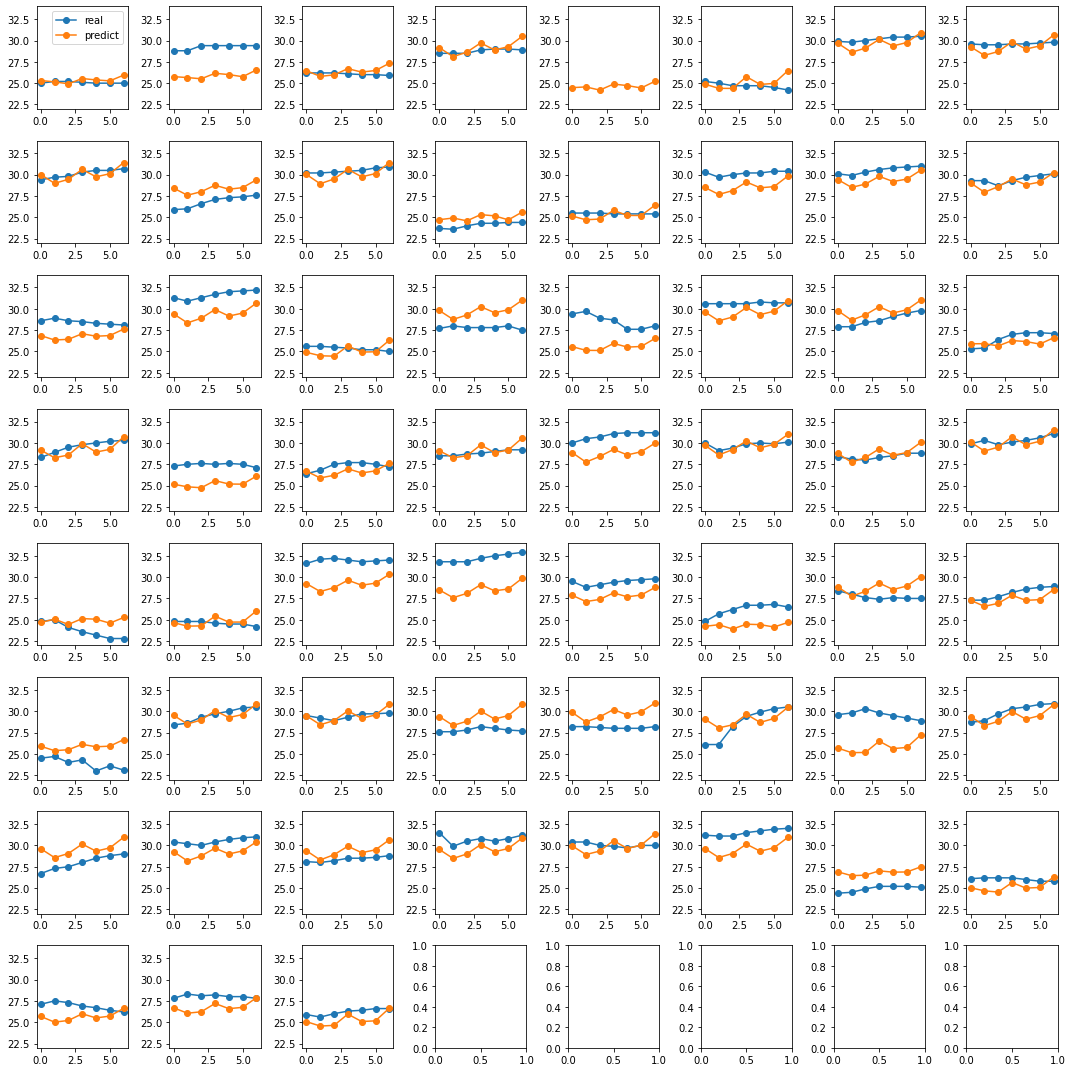

In [31]:
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k+1,k+9)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k,:], label = 'real', marker='o')
        axs[i,j].plot(yhat[k,:], label = 'predict', marker='o')
        axs[i,j].set_ylim(22,34)
        axs[0,0].legend()
    fig.tight_layout()
plt.savefig("./pics/tempPred.pdf", format="pdf")
plt.show()

In [157]:
differences = np.abs((yhat - test_y).mean(axis=1)).round(0).astype(int)
differences

array([1, 1, 4, 1, 2, 4, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 3,
       0, 2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 3, 3, 1, 2, 2, 2, 2, 1, 1,
       3, 1, 1, 3, 1, 3, 1, 2, 0, 1, 1, 3, 1, 1, 3, 0])

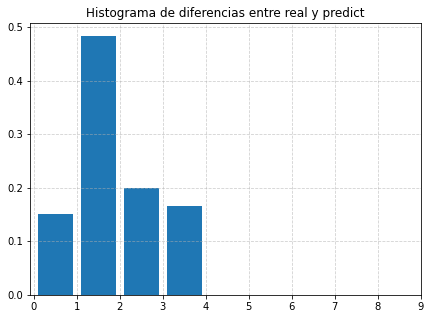

In [166]:
# DESPUES DE SELECCION (SIN V12)
fig = plt.figure(figsize =(7, 5))
plt.grid(linestyle = "--", alpha=0.6)
plt.hist(differences, bins= [0,1,2,3,4,5,6,7,8,9], density=True, rwidth=0.8, align='mid')
#plt.xticks(np.arange(0, 10, 1))
plt.title("Histograma de diferencias entre real y predict")
plt.show()

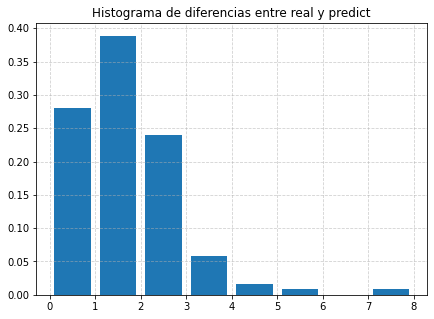

In [155]:
# ANTES DE LA SELECCION DE HIPERPARAMETROS
fig = plt.figure(figsize =(7, 5))
plt.grid(linestyle = "--", alpha=0.6)
plt.hist(differences, bins= 8, density=True, rwidth=0.8, align='mid')
plt.title("Histograma de diferencias entre real y predict")
plt.show()

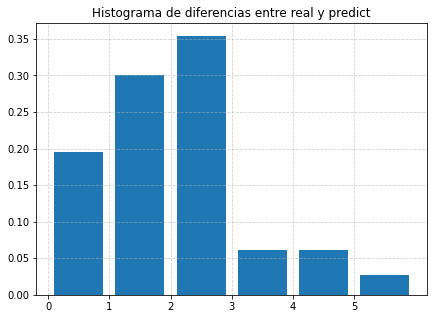

In [46]:
# DESPUES DE SELECCION (CON V12)
fig = plt.figure(figsize =(7, 5))
plt.grid(linestyle = "--", alpha=0.6)
plt.hist(differences, bins= 6, density=True, rwidth=0.8, align='mid')
plt.title("Histograma de diferencias entre real y predict")
plt.xticks(np.arange(0, 6, 1))
plt.show()

Cita del keras tuner:


@misc{omalley2019kerastuner,
    title        = {KerasTuner},
    author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
    year         = 2019,
    howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}

### -------------------------------- Cosas paso a paso -----------------------------------------

In [ ]:
#n_var = 10
#var_pos = reframed.columns.get_loc("var1(t-1)") 

index_y = list(range(var_pos,reframed.shape[1],n_var))   # Columnas 2,18,34,50,66,82,98
index_x = [val for val in list(range(0,reframed.shape[1],1))
           if val not in range(var_pos,reframed.shape[1],n_var)] #El resto
x = reframed.iloc[:, index_x].values
y = reframed.iloc[:, index_y].values

import numpy as np
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=123)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

pd.DataFrame(train_x)

n_intervals = 7 
n_features = n_var-1
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], n_intervals, n_features))
test_x = test_x.reshape((test_x.shape[0], n_intervals, n_features))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
#Forma del input de LSTM: (samples, time steps, features)

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Diseñamos la red
# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2]), stateful=False, dropout=0.5))
model.add(Dense(10))
model.add(Dense(7))
model.compile(loss='mae', optimizer='adam')

# Entrenamos el modelo
history = model.fit(train_x, train_y, epochs=50, batch_size=1, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_x)

yhat.shape

rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)
cvrmse = rmse/np.mean(test_y)*100
print('Test CVRMSE: %.3f' % cvrmse)